### Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import os
from tensorflow.keras import layers, Input
import matplotlib.image as mpimg
%matplotlib inline
import random
from tensorflow.keras.models import Model

### Import the Train images

We first start by viewing some random images from our dataset

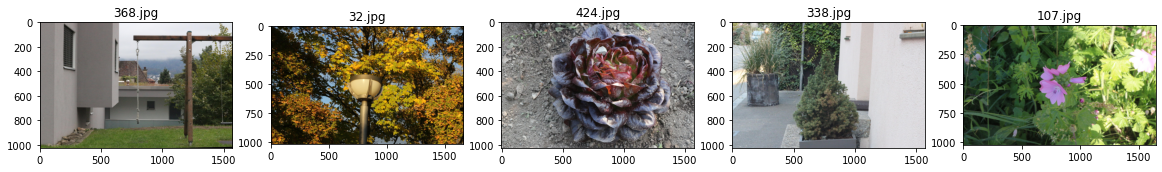

In [2]:
# Viewing some random images from our original dataset

plt.figure(figsize=(20,20))
img_folder= 'dataset/train/original/'
for i in range(5):
    file = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

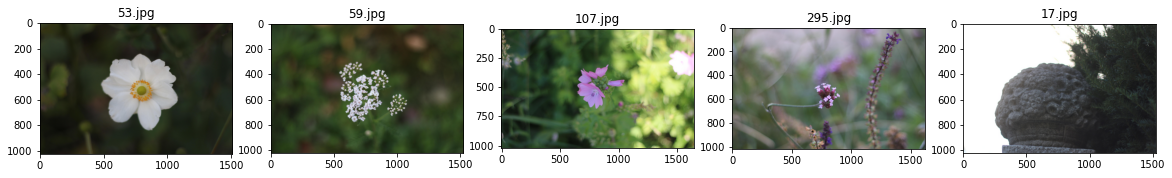

In [3]:
# Viewing some random images from our bokeh dataset
plt.figure(figsize=(20,20))
img_folder= 'dataset/train/bokeh/'
for i in range(5):
    file = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

Initializing dimensions of the images

In [4]:
IMG_HEIGHT = 512
IMG_WIDTH = 512

Specifying the directories of the train and test datasets

In [5]:
train_orig = 'dataset/train/original/'
train_bokeh = 'dataset/train/bokeh/'
test_orig = 'dataset/test/original/'
test_bokeh = 'dataset/test/bokeh/'

The below function creates the image data and the labels from the images in the folder

In [6]:
def create_dataset(img_folder):
    # Create empty arrays to store the data
    img_data_array=[]
    
    for file in os.listdir(img_folder):
       
        image_path= os.path.join(img_folder,file)
        image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
        image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
        image=np.array(image)
        image = image.astype('float32')
        image /= 255 
        img_data_array.append(image)
    
    return img_data_array

Importing the images

In [7]:
# importing train images (original)
train_orig_imgs = create_dataset(train_orig)
# importing train images (bokeh)
train_bokeh_imgs = create_dataset(train_bokeh)
# importing test images (original)
test_orig_imgs = create_dataset(test_orig)
# importing test images (bokeh)
test_bokeh_imgs = create_dataset(test_bokeh)

Converting the images into numpy array

In [8]:
train_orig_imgs = np.array(train_orig_imgs)
train_bokeh_imgs = np.array(train_bokeh_imgs)
test_orig_imgs = np.array(test_orig_imgs)
test_bokeh_imgs = np.array(test_bokeh_imgs)

### Model definition and training the model

In [9]:
# Parameters for the network
batch_size = 10
num_train_images = 460
instance_norm=True
instance_norm_level_1=False

Defining some functions that'll be used in the model

In [10]:
# Defining some functions that will be used in the model

def _conv_multi_block(input, max_size, num_maps, instance_norm):

    conv_3a = _conv_layer(input, num_maps, 3, 1, relu=True, instance_norm=instance_norm)
    conv_3b = _conv_layer(conv_3a, num_maps, 3, 1, relu=True, instance_norm=instance_norm)

    output_tensor = conv_3b

    if max_size >= 5:

        conv_5a = _conv_layer(input, num_maps, 5, 1, relu=True, instance_norm=instance_norm)
        conv_5b = _conv_layer(conv_5a, num_maps, 5, 1, relu=True, instance_norm=instance_norm)

        output_tensor = stack(output_tensor, conv_5b)

    if max_size >= 7:

        conv_7a = _conv_layer(input, num_maps, 7, 1, relu=True, instance_norm=instance_norm)
        conv_7b = _conv_layer(conv_7a, num_maps, 7, 1, relu=True, instance_norm=instance_norm)

        output_tensor = stack(output_tensor, conv_7b)

    if max_size >= 9:

        conv_9a = _conv_layer(input, num_maps, 9, 1, relu=True, instance_norm=instance_norm)
        conv_9b = _conv_layer(conv_9a, num_maps, 9, 1, relu=True, instance_norm=instance_norm)

        output_tensor = stack(output_tensor, conv_9b)

    return output_tensor

def stack(x, y):
    return tf.concat([x, y], 3)


def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def leaky_relu(x, alpha=0.2):
    return tf.maximum(alpha * x, x)


def _conv_layer(net, num_filters, filter_size, strides, relu=True, instance_norm=False, padding='SAME'):

    weights_init = _conv_init_vars(net, num_filters, filter_size)
    strides_shape = [1, strides, strides, 1]
    bias = tf.Variable(tf.constant(0.01, shape=[num_filters]))

    net = tf.nn.conv2d(net, weights_init, strides_shape, padding=padding) + bias

    if instance_norm:
        net = _instance_norm(net)

    if relu:
        net = leaky_relu(net)

    return net


def _instance_norm(net):

    batch, rows, cols, channels = [i for i in net.get_shape()]
    var_shape = [channels]

    mu, sigma_sq = tf.compat.v1.nn.moments(net, [1,2], keep_dims=True)
    shift = tf.Variable(tf.zeros(var_shape))
    scale = tf.Variable(tf.ones(var_shape))

    epsilon = 1e-3
    normalized = (net-mu)/(sigma_sq + epsilon)**(.5)

    return scale * normalized + shift


def _conv_init_vars(net, out_channels, filter_size, transpose=False):

    _, rows, cols, in_channels = [i for i in net.get_shape()]

    if not transpose:
        weights_shape = [filter_size, filter_size, in_channels, out_channels]
    else:
        weights_shape = [filter_size, filter_size, out_channels, in_channels]

    weights_init = tf.Variable(tf.compat.v1.truncated_normal(weights_shape, stddev=0.01, seed=1), dtype=tf.float32)
    return weights_init


def _conv_tranpose_layer(net, num_filters, filter_size, strides):
    weights_init = _conv_init_vars(net, num_filters, filter_size, transpose=True)

    net_shape = tf.shape(net)
    tf_shape = tf.stack([net_shape[0], net_shape[1] * strides, net_shape[2] * strides, num_filters])

    strides_shape = [1, strides, strides, 1]
    net = tf.nn.conv2d_transpose(net, weights_init, tf_shape, strides_shape, padding='SAME')

    return leaky_relu(net)


def max_pool(x, n):
    return tf.nn.max_pool(x, ksize=[1, n, n, 1], strides=[1, n, n, 1], padding='VALID')

Model & training

In [ ]:
# Training the model 

inputs = Input(shape=(512,512,3), batch_size=10)
# Space-to-depth layer

space2depth_l0 = tf.nn.space_to_depth(inputs, 2)                                         # 512 -> 256
        # -----------------------------------------
        # Downsampling layers

conv_l1_d1 = _conv_multi_block(space2depth_l0, 3, num_maps=32, instance_norm=False)     # 256 -> 256
pool1 = max_pool(conv_l1_d1, 2)                                                         # 256 -> 128

conv_l2_d1 = _conv_multi_block(pool1, 3, num_maps=64, instance_norm=instance_norm)      # 128 -> 128
pool2 = max_pool(conv_l2_d1, 2)                                                         # 128 -> 64

conv_l3_d1 = _conv_multi_block(pool2, 3, num_maps=128, instance_norm=instance_norm)     # 64 -> 64
pool3 = max_pool(conv_l3_d1, 2)                                                         # 64 -> 32

conv_l4_d1 = _conv_multi_block(pool3, 3, num_maps=256, instance_norm=instance_norm)     # 32 -> 32
pool4 = max_pool(conv_l4_d1, 2)                                                         # 32 -> 16

        # -----------------------------------------
        # Processing: Level 5,  Input size: 16 x 16

conv_l5_d1 = _conv_multi_block(pool4, 3, num_maps=512, instance_norm=instance_norm)
conv_l5_d2 = _conv_multi_block(conv_l5_d1, 3, num_maps=512, instance_norm=instance_norm) + conv_l5_d1
conv_l5_d3 = _conv_multi_block(conv_l5_d2, 3, num_maps=512, instance_norm=instance_norm) + conv_l5_d2
conv_l5_d4 = _conv_multi_block(conv_l5_d3, 3, num_maps=512, instance_norm=instance_norm)

conv_t4a = _conv_tranpose_layer(conv_l5_d4, 256, 3, 2)      # 16 -> 32
conv_t4b = _conv_tranpose_layer(conv_l5_d4, 256, 3, 2)      # 16 -> 32

        # -> Output: Level 5

conv_l5_out = _conv_layer(conv_l5_d4, 3, 3, 1, relu=False, instance_norm=False)
output_l5 = tf.nn.tanh(conv_l5_out) * 0.58 + 0.5

        # -----------------------------------------
        # Processing: Level 4,  Input size: 32 x 32

conv_l4_d2 = stack(conv_l4_d1, conv_t4a)
conv_l4_d3 = _conv_multi_block(conv_l4_d2, 3, num_maps=256, instance_norm=instance_norm)
conv_l4_d4 = _conv_multi_block(conv_l4_d3, 3, num_maps=256, instance_norm=instance_norm) + conv_l4_d3
conv_l4_d5 = _conv_multi_block(conv_l4_d4, 3, num_maps=256, instance_norm=instance_norm) + conv_l4_d4
conv_l4_d6 = stack(_conv_multi_block(conv_l4_d5, 3, num_maps=256, instance_norm=instance_norm), conv_t4b)

conv_l4_d7 = _conv_multi_block(conv_l4_d6, 3, num_maps=256, instance_norm=instance_norm)

conv_t3a = _conv_tranpose_layer(conv_l4_d7, 128, 3, 2)      # 32 -> 64
conv_t3b = _conv_tranpose_layer(conv_l4_d7, 128, 3, 2)      # 32 -> 64

        # -> Output: Level 4

conv_l4_out = _conv_layer(conv_l4_d7, 3, 3, 1, relu=False, instance_norm=False)
output_l4 = tf.nn.tanh(conv_l4_out) * 0.58 + 0.5

        # -----------------------------------------
        # Processing: Level 3,  Input size: 64 x 64

conv_l3_d2 = stack(conv_l3_d1, conv_t3a)
conv_l3_d3 = _conv_multi_block(conv_l3_d2, 5, num_maps=128, instance_norm=instance_norm) + conv_l3_d2
conv_l3_d4 = _conv_multi_block(conv_l3_d3, 5, num_maps=128, instance_norm=instance_norm) + conv_l3_d3
conv_l3_d5 = _conv_multi_block(conv_l3_d4, 5, num_maps=128, instance_norm=instance_norm) + conv_l3_d4
conv_l3_d6 = stack(_conv_multi_block(conv_l3_d5, 5, num_maps=128, instance_norm=instance_norm), conv_l3_d1)
conv_l3_d7 = stack(conv_l3_d6, conv_t3b)

conv_l3_d8 = _conv_multi_block(conv_l3_d7, 3, num_maps=128, instance_norm=instance_norm)

conv_t2a = _conv_tranpose_layer(conv_l3_d8, 64, 3, 2)       # 64 -> 128
conv_t2b = _conv_tranpose_layer(conv_l3_d8, 64, 3, 2)       # 64 -> 128

        # -> Output: Level 3

conv_l3_out = _conv_layer(conv_l3_d8, 3, 3, 1, relu=False, instance_norm=False)
output_l3 = tf.nn.tanh(conv_l3_out) * 0.58 + 0.5

        # -------------------------------------------
        # Processing: Level 2,  Input size: 128 x 128

conv_l2_d2 = stack(conv_l2_d1, conv_t2a)
conv_l2_d3 = stack(_conv_multi_block(conv_l2_d2, 5, num_maps=64, instance_norm=instance_norm), conv_l2_d1)

conv_l2_d4 = _conv_multi_block(conv_l2_d3, 7, num_maps=64, instance_norm=instance_norm) + conv_l2_d3
conv_l2_d5 = _conv_multi_block(conv_l2_d4, 7, num_maps=64, instance_norm=instance_norm) + conv_l2_d4
conv_l2_d6 = _conv_multi_block(conv_l2_d5, 7, num_maps=64, instance_norm=instance_norm) + conv_l2_d5
conv_l2_d7 = stack(_conv_multi_block(conv_l2_d6, 7, num_maps=64, instance_norm=instance_norm), conv_l2_d1)

conv_l2_d8 = stack(_conv_multi_block(conv_l2_d7, 5, num_maps=64, instance_norm=instance_norm), conv_t2b)
conv_l2_d9 = _conv_multi_block(conv_l2_d8, 3, num_maps=64, instance_norm=instance_norm)

conv_t1a = _conv_tranpose_layer(conv_l2_d9, 32, 3, 2)       # 128 -> 256
conv_t1b = _conv_tranpose_layer(conv_l2_d9, 32, 3, 2)       # 128 -> 256

        # -> Output: Level 2

conv_l2_out = _conv_layer(conv_l2_d9, 3, 3, 1, relu=False, instance_norm=False)
output_l2 = tf.nn.tanh(conv_l2_out) * 0.58 + 0.5

        # -------------------------------------------
        # Processing: Level 1,  Input size: 256 x 256

conv_l1_d2 = stack(conv_l1_d1, conv_t1a)
conv_l1_d3 = stack(_conv_multi_block(conv_l1_d2, 5, num_maps=32, instance_norm=False), conv_l1_d1)

conv_l1_d4 = _conv_multi_block(conv_l1_d3, 7, num_maps=32, instance_norm=False)

conv_l1_d5 = _conv_multi_block(conv_l1_d4, 9, num_maps=32, instance_norm=instance_norm_level_1)
conv_l1_d6 = _conv_multi_block(conv_l1_d5, 9, num_maps=32, instance_norm=instance_norm_level_1) + conv_l1_d5
conv_l1_d7 = _conv_multi_block(conv_l1_d6, 9, num_maps=32, instance_norm=instance_norm_level_1) + conv_l1_d6
conv_l1_d8 = _conv_multi_block(conv_l1_d7, 9, num_maps=32, instance_norm=instance_norm_level_1) + conv_l1_d7

conv_l1_d9 = stack(_conv_multi_block(conv_l1_d8, 7, num_maps=32, instance_norm=False), conv_l1_d1)

conv_l1_d10 = stack(_conv_multi_block(conv_l1_d9, 5, num_maps=32, instance_norm=False), conv_t1b)
conv_l1_d11 = stack(conv_l1_d10, conv_l1_d1)

conv_l1_d12 = _conv_multi_block(conv_l1_d11, 3, num_maps=32, instance_norm=False)

        # -> Output: Level 1

conv_l1_out = _conv_layer(conv_l1_d12, 3, 3, 1, relu=False, instance_norm=False)
output_l1 = tf.nn.tanh(conv_l1_out) * 0.58 + 0.5

        # ----------------------------------------------------------
        # Processing: Level 0 (x2 upscaling),  Input size: 256 x 256

conv_l0 = _conv_tranpose_layer(conv_l1_d12, 8, 3, 2)        # 256 -> 512
conv_l0_out = _conv_layer(conv_l0, 3, 3, 1, relu=False, instance_norm=False)
output_l0 = tf.nn.tanh(conv_l0_out) * 0.58 + 0.5

        # ----------------------------------------------------------
        # Processing: Level Up (x4 upscaling),  Input size: 512 x 512

conv_l_up = _conv_tranpose_layer(conv_l0_out, 3, 3, 2)  # 512 -> 1024
conv_l_up_out = _conv_layer(conv_l_up, 3, 3, 1, relu=False, instance_norm=False)

output_l_up = tf.nn.tanh(conv_l_up_out) * 0.58 + 0.5

In [12]:
model = Model(inputs = inputs, outputs = output_l0)

In [13]:
model.compile(loss =tf.keras.losses.MeanSquaredError(), optimizer = 'adam',metrics=['accuracy'] )
model.fit(train_orig_imgs,train_bokeh_imgs,validation_data = (test_orig_imgs,test_bokeh_imgs),epochs = 5,batch_size = batch_size)

Epoch 1/5
46/46 [==============================] - 9833s 212s/step - loss: 0.0658 - accuracy: 0.3399 - val_loss: 0.0767 - val_accuracy: 0.3154
Epoch 2/5
46/46 [==============================] - 9871s 215s/step - loss: 0.0658 - accuracy: 0.3399 - val_loss: 0.0767 - val_accuracy: 0.3154
Epoch 3/5
46/46 [==============================] - 10065s 219s/step - loss: 0.0658 - accuracy: 0.3399 - val_loss: 0.0767 - val_accuracy: 0.3154
Epoch 4/5
46/46 [==============================] - 10084s 220s/step - loss: 0.0658 - accuracy: 0.3399 - val_loss: 0.0767 - val_accuracy: 0.3154
Epoch 5/5
46/46 [==============================] - 11677s 254s/step - loss: 0.0658 - accuracy: 0.3399 - val_loss: 0.0767 - val_accuracy: 0.3154


In [14]:
# accuracy evaluation
score = model.evaluate(test_orig_imgs,
test_bokeh_imgs, batch_size=batch_size,verbose=0)
print("nTest accuracy: %.1f%%" % (100.0 * score[1]))

nTest accuracy: 31.5%
